### PatchTST
顾名思义，它利用了patching和transformer的结构。它还包括通道独立，以处理多变量时间序列。一般架构如下所示
<center><img src = 'pic/patchtst01.jpeg' width=500 > </center>
PatchTST模型结构。我们看到，该模型利用通道独立性来处理多变量的时间序列。在transformer主干中，我们也看到了patche的使用（由矩形说明）。另外，该模型有两个版本：有监督的和自监督的。

#### 通道独立
这里，多变量时间序列被认为是一个多通道信号。每个时间序列基本上都是一个包含信号的通道
<center><img src = 'pic/patchtst02.png' width=500 > </center>
PatchTST模型的概述。在这里，我们真正强调的是通道独立的实现，即每个输入到Transformer骨干网的标记只包含一个通道的信息，或一个时间序列

在上图中，我们看到一个多变量的时间序列是如何被分离成单个序列的，并且每个序列作为一个输入标记被送入Transformer主干网。然后，对每个系列进行预测，并将结果串联起来以获得最终的预测结果。

#### Patching
大多数关于基于transformer的预测模型的工作集中在建立新的机制来简化原有的注意力机制。然而，他们仍然依赖于点状的注意力，这在涉及到时间序列时并不理想。

在时间序列预测中，提取过去的时间步骤和未来的时间步骤之间的关系来进行预测。在关注点方面，从一个单一的时间步骤中获取信息，而不去看这个点周围的情况。换句话说，把一个时间步骤隔离开来，而不去看之前或之后的点。

这就像试图理解一个词的含义，而不看它周围在一个句子中的词。

因此，PatchTST利用patche来提取时间序列中的局部语义信息
#### Patching是如何工作的
每个输入序列都被划分为多个patche，这些patche是来自原始序列的较短序列。
<center><img src = 'pic/patchtst03.png' width=500 > </center>
PatchTST的transformer主干图。在这里，我们看到输入的时间序列（在图的底部）经过修补，产生了多个补丁（垂直的矩形），然后被发送到Transformer编码器。

这里，patche可以是重叠的或不重叠的。patche的数量取决于patche的长度P和步长S。在这里，步长就像卷积一样，它只是连续patche的开始之间有多少个时间步长。
<center><img src = 'pic/patchtst04.png' width=500 > </center>

可视化的patche。这里，我们有一个15个时间步长的序列，patche长度为5，步长也是5，结果是三个patche。

在上图中，我们可以直观地看到patche的结果。序列长度（L）为15个时间步骤，patche长度（P）为5，步长（S）为5。其结果是该序列被分成3个patches。

#### Patching的优点
通过patche，模型可以通过查看一组时间步骤，而不是查看单个时间步骤来提取局部语义。

它还有一个额外的好处，就是大大减少了被输入到transformer编码器的令牌数量。在这里，每个贴片都成为一个输入令牌，被输入到transformer中。这样，我们可以将令牌的数量从L 减少到大约L/S。

这样一来，我们就大大降低了模型的空间和时间复杂性。这反过来意味着我们可以给模型提供更长的输入序列以提取有意义的时间关系。

因此，通过patche，模型更快、更轻，并且可以处理更长的输入序列，这意味着它有可能学习更多关于该系列的知识并做出更好的预测。

#### transformer编码器
一旦串联被修补好，就会被送入transformer编码器。这就是经典的transformer结构，没有什么被修改。

然后，输出被送入线性层，并进行预测。

#### 用表征学习改进PatchTST
该论文的作者建议通过使用表征学习对模型进行另一种改进

<center><img src = 'pic/patchtst05.png' width=500 > </center>
在PatchTST中可视化自我监督的表示学习。在这里，模型将随机掩盖斑块并学习重建它们。

从上图中，我们可以看到PatchTST可以使用自我监督的表示学习来捕捉数据的抽象表示。这可以导致预测性能的潜在改善。

在这里，这个过程相当简单，因为随机斑块将被屏蔽，也就是说，它们将被设置为0。然后，模型被训练来重新创建原始斑块，这就是图中顶部的灰色垂直矩形的输出。

现在对PatchTST的工作原理有了一定的了解，把它与其他模型进行测试，看看它的表现如何。

#### 用PatchTST进行预测

在本文中，PatchTST与其他基于transformer的模型进行了比较。然而，最近发表的基于MLP的模型，如N-BEATS和N-HiTS，也在长视距预测任务上表现出最先进的性能。

这里应用PatchTST，以及N-BEATS和N-HiTS，并评估其与这两个基于MLP的模型的性能。

在这个练习中，我们使用Exchange数据集，这是研究中长时间序列预测的一个常见基准数据集。该数据集包含八个国家相对于美元的每日汇率，从1990年到2016年。

#### 初始设置
导入所需的库，并使用neuralforecast，一个PatchTST的开箱即用的库。对于数据集，使用datasetsforecast库，其中包括所有用于评估预测算法的流行数据集。

如果你安装了CUDA，那么neuralforecast会自动利用你的GPU来训练模型。

下载Exchange的数据集。
在这里，得到了三个DataFrames。第一个包含每个国家的每日汇率。第二个包含外生的时间序列。第三个，包含静态外生变量（如日、月、年、小时，或任何我们知道的未来信息）。

本案例中只对Y_df进行处理。并确保这些日期有正确的类型。

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, PatchTST
 
from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mae, mse
from datasetsforecast.long_horizon import LongHorizon
# 下载Exchange的数据集。
Y_df, X_df, S_df = LongHorizon.load(
              directory="./data", 
              group="Exchange")
# 处理数据类型
Y_df['ds'] = pd.to_datetime(Y_df['ds'] )
Y_df['y'] = Y_df['y'].astype('float')



Y_df['unique_id'].value_counts()


unique_id
0     7588
1     7588
2     7588
3     7588
4     7588
5     7588
6     7588
OT    7588
Name: count, dtype: int64

显示每个独特ID的观察数量

从上图中，每个唯一的id对应一个国家，每个国家有7588个观察值。

现在定义验证集和测试集的大小。选择了760个时间步骤作为验证，1517个时间步骤作为测试集，这是由数据集库[3]指定的。

In [3]:
val_size = 760
test_size = 1517

In [4]:
u_id = '0'
 
x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y

n_time = x_plot.shape[0]
n_time



7588

然后绘制其中一个系列。这里绘制第一个国家（unique_id = 0）的系列，但也可以随意绘制另一个系列

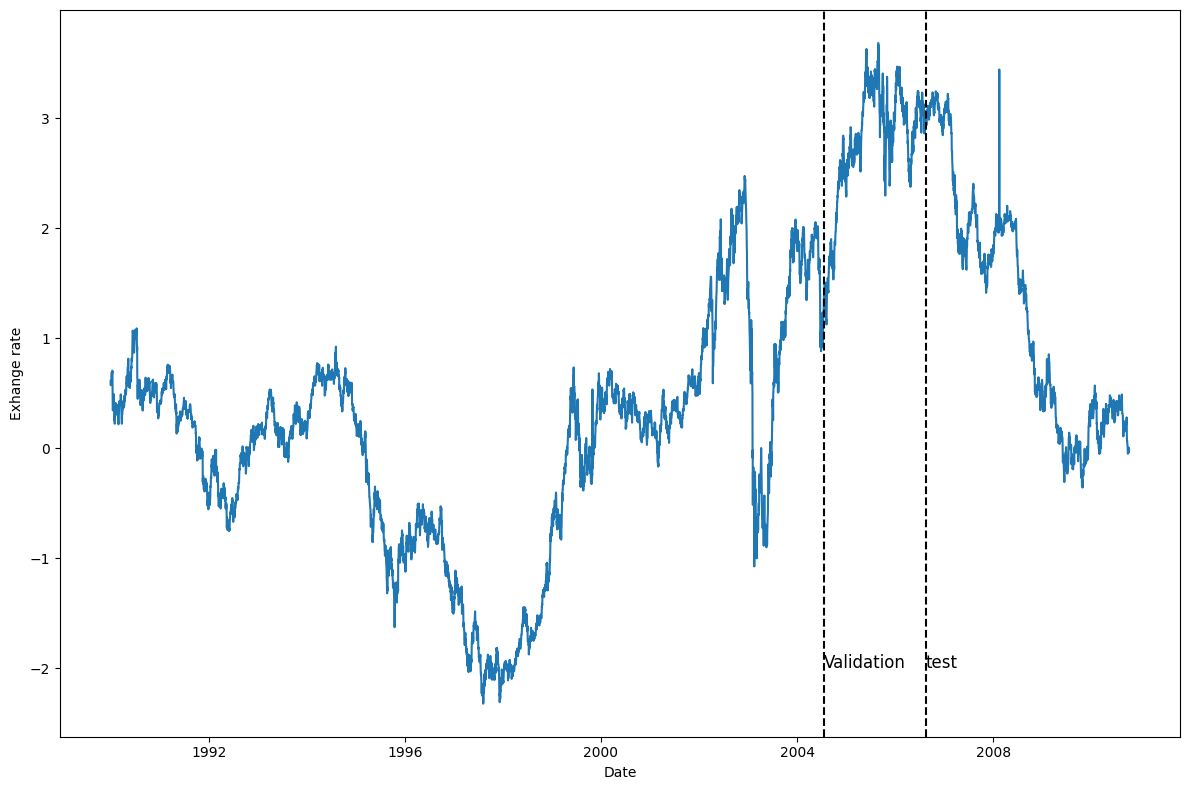

In [3]:

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x_plot, y_plot)
ax.set_xlabel('Date')
ax.set_ylabel('Exhange rate')
ax.axvline(x_val, color='black', linestyle='--')
ax.axvline(x_test, color='black', linestyle='--')
 
plt.text(x_val, -2, 'Validation', fontsize=12)
plt.text(x_test,-2, 'test', fontsize=12)
 
plt.tight_layout()

第一个国家的每日汇率，从1990年到2016年

从上图中可以看到，数据相当嘈杂，没有明显的季节性。



#### 建模
在探索了数据之后，开始用neuralforecast进行建模。

首先，需要设置horizon。在这种情况下，使用96个时间步长，因为在PatchTST的论文[4]中也使用了这个horizon。

然后，为了对每个模型进行公平的评估，将输入大小设置为水平线的两倍（所以是192个时间步长），并将最大历时数设置为50。所有其他的超参数都保持其默认值。
#### **特别说明 需要安装 pip install protobuf==3.19.6  高版本和低版本都不行。**

In [4]:
horizon = 96
 
models = [NHITS(h=horizon,input_size=2*horizon,max_steps=50),
          NBEATS(h=horizon,input_size=2*horizon,max_steps=50),
          PatchTST(h=horizon,input_size=2*horizon,max_steps=50)]

# models = [PatchTST(h=horizon,input_size=2*horizon,max_steps=50)]
nf = NeuralForecast(models=models, freq='D')

#为了生成预测，使用cross_validation方法来利用验证和测试集。它将返回一个包含所有模型的预测值和相关真值的数据框架。
preds_df = nf.cross_validation(df=Y_df,val_size=val_size,test_size=test_size,n_windows=None)
# 
preds_df

Seed set to 1
Seed set to 1
Seed set to 1
D:\anaconda3\envs\gxg\lib\site-packages\neuralforecast\common\_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.9 M 
-----------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.775    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s, v_num=0, train_loss_step=0.203, train_loss_epoch=0.209]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  0.81it/s, v_num=0, train_loss_step=0.203, train_loss_epoch=0.203, valid_loss=0.280]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:01<00:00,  0.81it/s, v_num=0, train_loss_step=0.203, train_loss_epoch=0.203, valid_loss=0.280]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.75it/s]


D:\anaconda3\envs\gxg\lib\site-packages\neuralforecast\common\_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.1 M 
-----------------------------------------------
3.0 M     Trainable params
55.6 K    Non-trainable params
3.1 M     Total params
12.247    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s, v_num=2, train_loss_step=0.205, train_loss_epoch=0.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, v_num=2, train_loss_step=0.205, train_loss_epoch=0.205, valid_loss=0.294]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s, v_num=2, train_loss_step=0.205, train_loss_epoch=0.205, valid_loss=0.294]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 697 K 
---------------------------------------------------
697 K     Trainable params
3         Non-trainable params
697 K     Total params
2.791     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 1/1 [00:02<00:00,  0.37it/s, v_num=4, train_loss_step=0.214, train_loss_epoch=0.228]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 49: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=4, train_loss_step=0.214, train_loss_epoch=0.214, valid_loss=0.250]

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:08<00:00,  0.12it/s, v_num=4, train_loss_step=0.214, train_loss_epoch=0.214, valid_loss=0.250]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:14<00:00,  0.07it/s]


D:\anaconda3\envs\gxg\lib\site-packages\neuralforecast\core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,cutoff,NHITS,NBEATS,PatchTST,y
unique_id,,,,,,
0,2006-08-16,2006-08-15,2.924328,2.887193,2.907044,2.948076
0,2006-08-17,2006-08-15,2.927994,2.889350,2.927490,3.049320
0,2006-08-18,2006-08-15,2.921407,2.906753,2.932774,3.064168
0,2006-08-19,2006-08-15,2.916320,2.883437,2.948636,3.005783
0,2006-08-20,2006-08-15,2.930641,2.934332,2.943420,3.010031
...,...,...,...,...,...,...
OT,2010-10-06,2010-07-06,1.313704,1.251837,1.349651,0.902640
OT,2010-10-07,2010-07-06,1.322576,1.264367,1.314651,0.953585
OT,2010-10-08,2010-07-06,1.304765,1.259756,1.327368,0.956124


正如你所看到的，对于每个id，我们有每个模型的预测值，以及y列的真实值。

现在，为了评估模型，我们必须重新塑造实际值和预测值的数组，使其具有一定的形状（序列数、窗口数、预测范围）

完成这些后，可以选择绘制模型的预测结果。这里，我们在第一个系列的第一个窗口中绘制预测结果

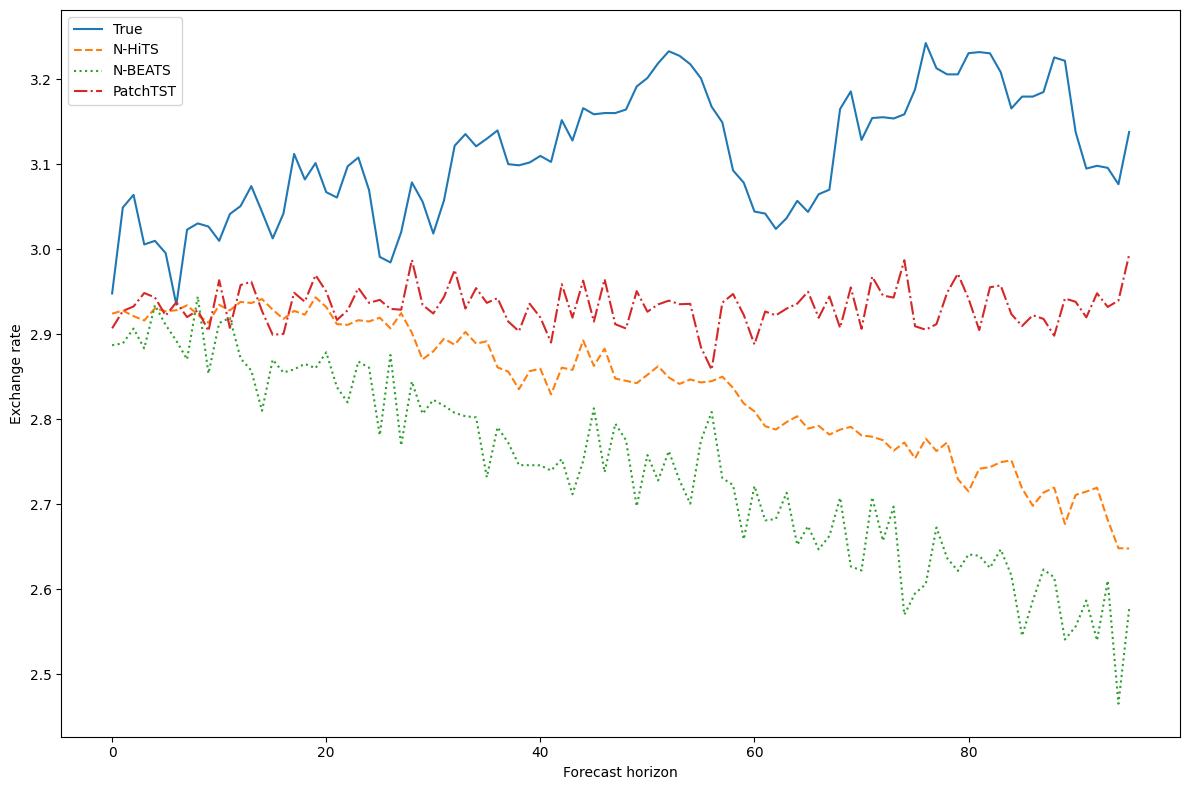

In [7]:
y_true = preds_df['y'].values
y_pred_nhits = preds_df['NHITS'].values
y_pred_nbeats = preds_df['NBEATS'].values
y_pred_patchtst = preds_df['PatchTST'].values
 
n_series = len(Y_df['unique_id'].unique())
 
y_true = y_true.reshape(n_series, -1, horizon)
y_pred_nhits = y_pred_nhits.reshape(n_series, -1, horizon)
y_pred_nbeats = y_pred_nbeats.reshape(n_series, -1, horizon)
y_pred_patchtst = y_pred_patchtst.reshape(n_series, -1, horizon)

fig, ax = plt.subplots(figsize=(12,8))
 
ax.plot(y_true[0, 0, :], label='True')
ax.plot(y_pred_nhits[0, 0, :], label='N-HiTS', ls='--')
ax.plot(y_pred_nbeats[0, 0, :], label='N-BEATS', ls=':')
ax.plot(y_pred_patchtst[0, 0, :], label='PatchTST', ls='-.')
ax.set_ylabel('Exchange rate')
ax.set_xlabel('Forecast horizon')
ax.legend(loc='best')
 
plt.tight_layout()

第一个系列的日汇率预测，在第一个窗口

这个数字不太理想，因为N-BEATS和N-HiTS的预测值似乎与实际值有很大偏差。然而，PatchTST虽然也有偏差，但似乎是最接近实际值的。

当然，我们必须谨慎对待，因为只是在一个预测窗口中对一个系列的预测进行了可视化。

#### 模型评估
接下来评估每个模型的性能。为了复现论文中的方法，我们同时使用MAE和MSE作为性能指标。

In [8]:
data = {'N-HiTS':[mae(y_pred_nhits, y_true), mse(y_pred_nhits, y_true)],
    'N-BEATS':[mae(y_pred_nbeats, y_true), mse(y_pred_nbeats, y_true)],
    'PatchTST':[mae(y_pred_patchtst, y_true), mse(y_pred_patchtst, y_true)] }
 
metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']
 
metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,PatchTST
mae,0.196899,0.203219,0.198060
mse,0.077887,0.081319,0.081693


所有模型的性能。这里，PatchTST实现了最低的MAE和MSE

在上表中看到PatchTST是SOTA模型，因为它获得了最低的MAE和MSE。

当然，这不是最彻底的实验，因为我们只用了一个数据集和一个预测范围。不过，看到基于Transformer的模型能够与最先进的MLP模型竞争，还是很有意思的。